# Week 8: Parameter Estimation

In [1]:
# Loading the libraries
import numpy as np
#import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import scipy.optimize as opt
#from scipy.integrate import quad

## Day 2: Maximum Likelihood Estimation

So far we have been using probability distributions to calculate probabilities.

For example, let's say that we toss a fair coin five times. If $H$ is the random variable that counts how many heads we got in the five tosses, then we can calculate the probability of getting four heads. In other words, since $H$ follows a binomial distribution with $n=5$ and $p=0.5$, i.e. $H \sim \mathcal{B}(5, 0.5)$, we can calculate that $P(H=4) = 0.15625$. This calculation means: *if you know the distribution and its parameters, then you can easily calculate the probabilities/likelihods for the outcomes*

Now, let's turn the tables.

Say we know that someone has been doing series of coin tosses, and has been counting the number of heads obtained in each of the series. The number of heads obtained are as such:
$$1, 2, 2, 3, 4, 7$$
We can immediately conclude, if $X$ is the number of heads in one series of tosses, that:
* $X$ follows a binomial distribution (fixed number of independent success/failure trials with equal probability for success in each trial)
* $X \sim \mathcal{B}(n, p)$, but we do not know $n$ and $p$
* We could assume that $n=7$, the maximum number of heads observed in a single series. In other words, we assume this is a series in which all tosses turned up heads
* The question next is: how do we figure out the value for $p$? This corresponds to the following quest: *if you know the distribution, and the outcomes, how can you estimate the parameters of the distribution?*

The goal is, given some known distribution and some "experimental" data, to find the parameters of the distribution that is most likely to have produced the data. For our data this means that the outcomes above could have been produced by *any* binomial distribution $\mathcal{B}(7, p)$, but we are interested in finding the value of $p$ such that the distribution with that value is most likely to have produced those outcomes.

Given the quest, the method we use (today) to find the distribution is called **Maximum Likelihood** method, and the estimate of the parameters it produces are called **Maximum Likelihood Estmates (MLEs)**.


### How does it work?
Let $X$ be a random variable with some parameter $\theta$ which we want to estimate, and let $p(X=x \mid \theta)$ be the probability density function of $X$. Let's assume that the data/outcomes we obtained are given in the set $D = \{ x_1, x_2, \ldots, x_n \}$. Then the likelihood $\text{lik}(D \mid \theta)$ of us observing that sequence of outcomes, assuming independence, is given as:
$$
\begin{aligned}
\text{lik}(D \mid \theta) &= p(X=x_1 \mid \theta) \cdot p(X=x_2 \mid \theta) \cdot\ldots\cdot p(X=x_n \mid \theta) =\\
&= \prod_{i=1}^n p(X=x_i \mid \theta)
\end{aligned}
$$
The maximum likelihood estimate of the parameter $\theta$, denoted as $\hat{\theta}$, is given by:
$$
\hat{\theta} = \max_{\text{for all } \theta} \big\{ \text{lik}(D \mid \theta) \big \}
$$
From a practical standpoint, it is always better to to maximize the logarithm of the likelihoods via the so called **log-likelihood** function $L(D\mid\theta)$ which is given by:
$$
L(D\mid\theta) = \ln \big[ \text{lik}(D \mid \theta) \big]  = \sum_{i=1}^n \ln \big[ p(X=x_i \mid \theta) \big]
$$
so in that sense:
$$
\hat{\theta} = \max_{\text{for all } \theta} \big\{ L(D \mid \theta) \big\}
$$
This means that to find the $\hat\theta$ we just have to define the likelihood or log-likehoood function and find its maximum using some optimization algorithm.

## Example 1
Six series of seven tosses of a coin are made. Let $X$ be the random variable that counts how many heads we get in each of the series. Then $X \sim \mathcal{B}(7, p)$. The results of the six series of tosses are:
$$1, 2, 2, 3, 4, 7$$
Estimate the most likely value for the parameter $p$ (in other words: find the maximum likelihood estimator of $p$).

In [4]:
# Get the initial things
heads = np.array([1, 2, 2, 3, 4, 7])
n = 7
p_0 = 0.5

# Using lik
def lik_bin(theta, data):
    return -np.product(stats.binom(n=7, p=theta).pmf(data)) # "-" in the begining is for the minimization to work

lik_opt = opt.minimize(lik_bin,
                       p_0,
                       args=(heads),
                       method='Nelder-Mead')

lik_opt

 final_simplex: (array([[0.45234375],
       [0.45244141]]), array([-1.0405456e-06, -1.0405454e-06]))
           fun: -1.0405455997695717e-06
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([0.45234375])

In [5]:
# Using L
def L(theta, data):
    return -np.sum( np.log( stats.binom(n=7, p=theta).pmf(data) ) )

L_opt = opt.minimize(L, p_0, args=(heads), method='Nelder-Mead')
L_opt

 final_simplex: (array([[0.45234375],
       [0.45244141]]), array([13.77576537, 13.77576556]))
           fun: 13.775765367210369
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([0.45234375])

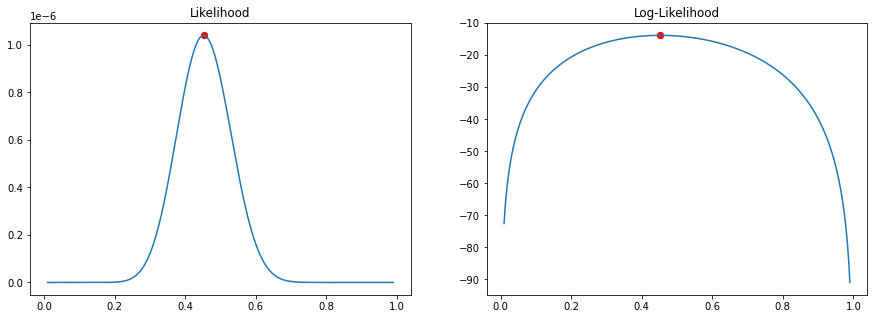

In [11]:
# plot the likelihood functions

xs = np.linspace(0.01, 0.99, 1000) # all theta (p) values for B(7, p)
ys = np.array([ -lik_bin(theta, heads) for theta in xs ]) # the lik_bin values
zs = np.array([ -L(theta, heads) for theta in xs ]) # the L values
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(xs, ys)
plt.scatter(L_opt.x[0], -lik_bin(L_opt.x[0], heads), s=40, c='r')
plt.title('Likelihood')

plt.subplot(122)
plt.plot(xs, zs)
plt.scatter(L_opt.x[0], -L(L_opt.x[0], heads), s=40, c='r')
plt.title('Log-Likelihood')
plt.show()

## Example 2
Tim counts the number of cars running the red light at a traffic light. In seven consecutive observations he counts:
$$
0, 0, 0, 1, 1, 2, 3
$$
cars running on a red light. He finds it reasonable to assume that a Poisson distribution $Po(\lambda)$ is appropriate to model the number of cars running the red light. If $X \sim Po(\lambda)$, then the densityfunction of $X$ is given by:
$$
p(X = k \mid \lambda) = \frac{\lambda^k}{k!} \cdot e^{-\lambda}
$$
for integer $k=0, 1, \ldots$ and $\lambda >0$.

Help Tim calculate the maximum likelihood estimate $\hat\lambda$ of the mean number of cars running the red light.

In [21]:
from math import factorial

# Get the basic info
cars = np.array([0, 0, 0, 1, 1, 2, 3])
lambda_0 = 3.0

# define L
def L(lmbd, data):
    #uising scipy.stats
    #return -np.sum( np.log( stats.poisson(lmbd).pmf(data) ) )
    #return -np.sum( stats.poisson(lmbd).logpmf(data) )
    # write the density from scratch
    return -np.sum( np.log( (lmbd**data / factorial(data)) * np.exp(-lmbd) ) ) # not vectorized, does not work!

# maximize
L_opt = opt.minimize(L, lambda_0, args=(cars), method='Nelder-Mead')
L_opt

 final_simplex: (array([[0.99997559],
       [1.00004883]]), array([9.48490665, 9.48490666]))
           fun: 9.484906651874198
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([0.99997559])

In [17]:
np.sum(np.log(stats.poisson(3.0).pmf([4, 3])))

-3.2795272788992325

## Example 3
This example is about modeling the accuracy of a certain rifle. Let's assume that the rifle is aimed at the center of a target which coincides with the origin $O$ of a coordinate system. 100 shots are made from a predetermined distance and the coordinates of the hits relative to $O$ are observed. These are given in the file `shooting_accuracy.csv`. All measurements are in decimeters (tens of centimeters).

The *distances* between the center of the target and the hits follow a certain pattern. It can be shown that the distribution which describes this pattern is a **Rayleigh distribution**. This distribution has only one parameter, $\sigma$, and a density function given by:
$$
p(x \mid \sigma) = \frac{x}{\sigma^2} \cdot e^{-x^2 /(2\sigma^2)}
$$
Based on the given data, find the maximum likelihood estimate of the parameter $\sigma$ of the distribution that describes the distances between the center of the target and the hits for the rifle which is being tested.

In [61]:
# Loading the data
df = pd.read_csv('shooting_accuracy.csv')
df.head()

,x,y
0,-1.90,-1.51
1,1.78,0.48
2,0.53,1.10
3,-0.45,0.57
4,-0.80,1.45


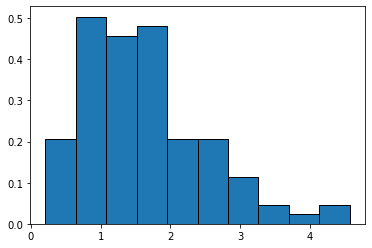

In [62]:
# Get the coordinates arrays
x = df['x'].to_numpy()
y = df['y'].to_numpy()

# Calculate the distances
d = np.sqrt(x**2 + y**2)

# Plot the distances on a DENSITY histogram
plt.figure()
plt.hist(d, edgecolor='k', density=True)
plt.show()

In [63]:
# Define the density function
def rayleigh_pdf(x, sigma):
    s2 = sigma**2
    return (x / s2) * np.exp( -x**2 / (2*s2) )
    #return x * np.exp(-0.5 * x**2 / s2) / s2
    
# Define the log-likehood function
def L(sigma, data):
    return -np.sum( np.log( rayleigh_pdf(data, sigma) ) )


In [64]:
# Estimate the max of the log-likelihood
sigma_0 = 1.0

L_opt = opt.minimize(L, sigma_0, args=(d), method='Nelder-Mead')

sigma_opt = L_opt.x[0]

L_opt

 final_simplex: (array([[1.29931641],
       [1.29921875]]), array([120.55662442, 120.55662548]))
           fun: 120.55662442182009
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([1.29931641])

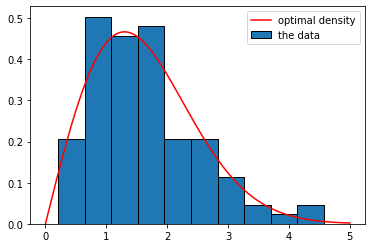

In [65]:
# Visualize the results
# (the likelihood and the density fit over the data)
xs = np.linspace(0, 5, 1000)
ys = np.array([ rayleigh_pdf(x, sigma_opt) for x in xs ])


plt.figure()
plt.hist(d, edgecolor='k', density=True, label='the data')
plt.plot(xs, ys, c='r', label='optimal density')
plt.legend()
plt.show()

## Example 4 (practice)
The data in the data given below contains the time intervals (in minutes) between successive arrivals of customers at a checkout counter in a supermarket. In such cases experience has shown that an appropriate distribution to use for modeling is the **exponential distribution**. It has one parameter $\theta >0$ and a density function:
$$
p(t \mid \theta) = \tfrac{1}{\theta} \cdot e^{-t/\theta}
$$
for $t \geqslant 0$. Find the maximum likelihood estimate $\hat\theta$ of the parameter $\theta$ for the exponential distribution that models the time intervals between arrivals.

In [ ]:
# times between arrivals
times = np.array([1, 2, 3, 7, 11, 4, 13,
                  12, 7, 3, 2, 11, 7, 2])

# Build the model


In [ ]:
# Visualize


## Example 5
Men in the Dinaric Alps region of the Balkan Peninsula are, on average, among the tallest men on the Earth. The file `dinaric_alps.csv` conains data about the heights of some men who were born and live in the region.

Given the data, and assuming that heights follow a normal distribution in the population of men, use maximum likelihood estimation to estimate the mean $\mu$ and the standard deviation $\sigma$ of the heights in the population of men in the Dinaric Alps region.

**Note:** the actual values are: `mu = 185.6` and `sigma = 7.42`

,heights
0,197.7
1,181.1
2,181.7
3,177.6
4,192.0


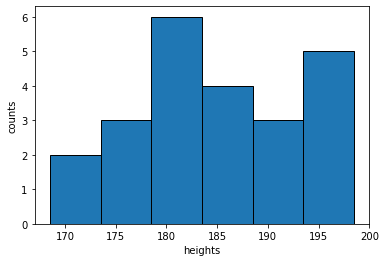

In [55]:
df = pd.read_csv('dinaric_alps.csv')
display(df.head())

#sns.histplot(data=df)

plt.figure()
plt.hist(df['heights'], edgecolor='k', bins=6)
plt.xlabel('heights')
plt.ylabel('counts')
plt.show()

In [58]:
# Build the model and find the MLEs
heights = df['heights'].to_numpy()
par_0 = np.array([175.0, 5.0])

# define L
def L(par, data):
    return -np.sum( stats.norm(par[0], par[1]).logpdf(data) )

L_opt = opt.minimize(L, par_0, args=(heights), method='Nelder-Mead')
L_opt

 final_simplex: (array([[185.03914394,   8.15121079],
       [185.03908761,   8.15119879],
       [185.03907536,   8.15123236]]), array([80.8934403, 80.8934403, 80.8934403]))
           fun: 80.8934403022327
       message: 'Optimization terminated successfully.'
          nfev: 113
           nit: 59
        status: 0
       success: True
             x: array([185.03914394,   8.15121079])

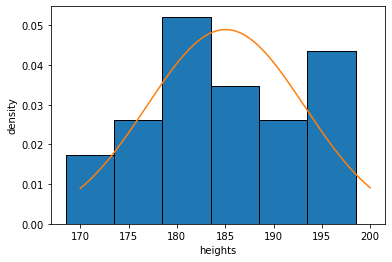

In [60]:
# Visualize the fit
xs = np.linspace(170, 200, 1000)
ys = np.array([ stats.norm(L_opt.x[0], L_opt.x[1]).pdf(x) for x in xs ])


plt.figure()
plt.hist(df['heights'], edgecolor='k', bins=6, density=True)
plt.plot(xs, ys)
plt.xlabel('heights')
plt.ylabel('density')
plt.show()